In [34]:
import tensorflow as tf
from tensorflow.keras import layers,models,optimizers
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [24]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.cifar10.load_data()        # returns x_train,x_test,y_test and y_train as numpy arrays

In [25]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [26]:
x_train = tf.keras.applications.mobilenet_v2.preprocess_input(x_train)
x_test = tf.keras.applications.mobilenet_v2.preprocess_input(x_test)

In [27]:
IMG_SIZE = 224 # Target size for MobileNetV2
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BASE_LEARNING_RATE = 0.0001
FINE_TUNE_EPOCHS = 20

In [28]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False, # Exclude the final classifier layer
    weights='imagenet' # Use weights pre-trained on ImageNet
)

In [29]:
model = models.Sequential()
model.add(layers.Resizing(IMG_SIZE, IMG_SIZE, input_shape=(32, 32, 3)))
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(10, activation='softmax'))

base_model.trainable = False
model.compile(
    optimizer=optimizers.Adam(learning_rate=BASE_LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

d:\Anaconda\envs\tf-env\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [30]:

print("--- Phase 1: Training only the new classifier head (Frozen Base) ---")
history_phase1 = model.fit(
    x_train, y_train,
    epochs=10,
    validation_data=(x_test, y_test)
)

--- Phase 1: Training only the new classifier head (Frozen Base) ---
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 374s 238ms/step - accuracy: 0.5465 - loss: 1.3821 - val_accuracy: 0.7956 - val_loss: 0.6227
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 435s 278ms/step - accuracy: 0.8051 - loss: 0.5842 - val_accuracy: 0.8226 - val_loss: 0.5293
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 410s 263ms/step - accuracy: 0.8315 - loss: 0.4969 - val_accuracy: 0.8359 - val_loss: 0.4930
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 411s 263ms/step - accuracy: 0.8405 - loss: 0.4637 - val_accuracy: 0.8379 - val_loss: 0.4747
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 379s 243ms/step - accuracy: 0.8495 - loss: 0.4430 - val_accuracy: 0.8423 - val_loss: 0.4595
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 372s 238ms/step - accuracy: 0.8539 - loss: 0.4253 - val_accuracy: 0.8466 - val_loss: 0.4505
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 375s 240ms/step - accuracy: 0.8579 - loss: 0.4150 - val_accuracy: 0.8480 - val_loss: 

In [31]:
# 1. Model Checkpoint: Saves the best version of the model based on validation accuracy
checkpoint_filepath = 'best_mobilenetv2_cifar10_weights.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,     # Only saves the weights, which are smaller
    monitor='val_accuracy',     # Metric to monitor for improvement
    mode='max',                 # We want to maximize the validation accuracy
    save_best_only=True         # CRUCIAL: Only save when a new best is reached
)

# 2. Early Stopping: Stops training when no improvement is seen
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', # Monitor the same metric as the checkpoint
    patience=3,             # Number of epochs to wait after no improvement before stopping
    verbose=1,              # Print a message when training is stopped
    mode='max',
    restore_best_weights=True # Restores the weights of the best epoch found
)
# Combine the callbacks into a list
callbacks_list = [model_checkpoint_callback, early_stopping_callback]

In [32]:
base_model.trainable = True
# We only want to fine-tune the top layers, so freeze early layers again
# The deeper layers contain general features; the top layers contain task-specific features
# You can set a number (e.g., layers[:100]) or a percentage here.
for layer in base_model.layers[:-50]: # Unfreeze the last ~50 layers
    layer.trainable = False
# Re-compile the model (MANDATORY after changing trainable status)
# Use a much lower learning rate for fine-tuning to prevent overwriting ImageNet weights
model.compile(
    optimizer=optimizers.Adam(learning_rate=BASE_LEARNING_RATE / 10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- Phase 2: Fine-Tuning top layers of the base model ---")
history_phase2 = model.fit(
    x_train, y_train,
    epochs=10 + FINE_TUNE_EPOCHS, # Train up to a total of 30 epochs (10 + 20)
    initial_epoch=10,             # Resume from the end of phase 1
    validation_data=(x_test, y_test)
    ,callbacks=callbacks_list
)




--- Phase 2: Fine-Tuning top layers of the base model ---
Epoch 11/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 577s 365ms/step - accuracy: 0.8177 - loss: 0.5426 - val_accuracy: 0.8802 - val_loss: 0.3545
Epoch 12/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 531s 340ms/step - accuracy: 0.8924 - loss: 0.3150 - val_accuracy: 0.8902 - val_loss: 0.3213
Epoch 13/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 527s 337ms/step - accuracy: 0.9155 - loss: 0.2487 - val_accuracy: 0.8991 - val_loss: 0.2961
Epoch 14/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 528s 338ms/step - accuracy: 0.9355 - loss: 0.1906 - val_accuracy: 0.9088 - val_loss: 0.2733
Epoch 15/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 530s 339ms/step - accuracy: 0.9474 - loss: 0.1569 - val_accuracy: 0.9134 - val_loss: 0.2621
Epoch 16/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 529s 338ms/step - accuracy: 0.9612 - loss: 0.1222 - val_accuracy: 0.9155 - val_loss: 0.2551
Epoch 17/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 532s 341ms/step - accuracy: 0.9717 - loss: 0.0941 - val_accuracy: 0.9158 - val_loss: 0.2

In [33]:
# Final Evaluation ---
loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f"\nFinal MobileNetV2 Test Accuracy: {accuracy*100:.2f}%")

313/313 - 59s - 188ms/step - accuracy: 0.9215 - loss: 0.2605

Final MobileNetV2 Test Accuracy: 92.15%


In [35]:
IMG_SIZE = 224
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
def predict_new_image(model, image_path):
    """
    Loads, preprocesses, and predicts the class of a single new image
    for the MobileNetV2 model.
    """
    # 1. Load the image
    img = Image.open(image_path).convert('RGB')

    # 2. Resize to the target size (224x224)
    img = img.resize((IMG_SIZE, IMG_SIZE))

    # 3. Convert to NumPy array and add batch dimension
    img_array = np.array(img, dtype=np.float32)
    img_array = np.expand_dims(img_array, axis=0) # Shape: (1, 224, 224, 3)

    # 4. Apply MobileNetV2's specific normalization (scales to [-1, 1])
    preprocessed_img = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    # 5. Make prediction
    predictions = model.predict(preprocessed_img)
    
    # Get the class index and confidence
    predicted_class_index = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_index]
    predicted_label = class_names[predicted_class_index]

    # 6. Display result
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label} ({confidence*100:.2f}%)")
    plt.axis('off')
    plt.show()

    return predicted_label, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


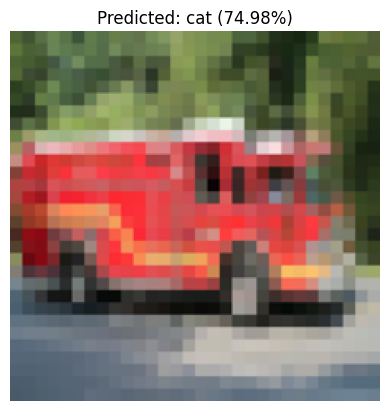

('cat', np.float32(0.7497617))

In [42]:
# Low-Resolution Image
predict_new_image(model,'test_images/truck_9_sample.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


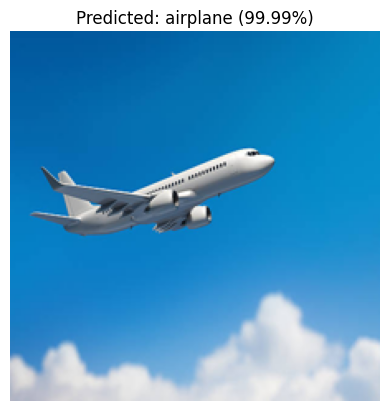

('airplane', np.float32(0.9999279))

In [43]:
# High-Resolution Image -1
predict_new_image(model , 'test_images/airplane_test.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


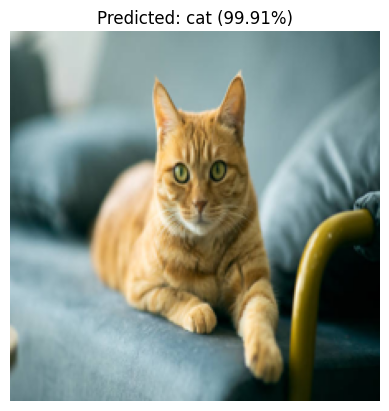

('cat', np.float32(0.9990645))

In [44]:
# High-Resolution Image -2
predict_new_image(model, 'test_images/cat_test.jpg')  